In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load modules related to this exercise
import tools 
from model import model_class

import time # For timing speed

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

This file is for computing the speed/acurracy tradeoff for the simple consumption saving model using EGM and FD.

### Generate the 'true' policy functions

Setup model

In [2]:
# Maximum grid points is 4000 right now
max_nr = 4000
m_max = 20

# Setup model
model = model_class()
model.setup()
model.create_grids()

Run EGM

In [4]:
# Compute policy functions
model.par.Na = max_nr-1 # Set number
model.m_max = m_max

model.create_grids()
model.solve_egm()
c_egm_tr = model.sol_egm.c

# Save fine asset grid for later interpolation
m_egm_tr = model.sol_egm.m

Run FD

In [3]:
# Compute policy functions
model.par.Nm = max_nr
model.par.m_max = m_max
model.create_grids()
model.solve_fd()
c_fd_tr = model.sol_fd.c

# Save fine asset grid for later interpolation
m_fd_tr = model.sol_fd.m

Compute the errors

In [25]:
# Points on the grid
num = 50
Na_vec = tools.nonlinspace(50,2000,num,1.3)

# Initialize result vectors
error_egm = np.nan + np.zeros(num)
time_egm = np.nan + np.zeros(num)

for i,Na in enumerate(Na_vec):
    
    # Setup model
    model = model_class()
    model.setup()
    model.par.Na = int(Na) # Set number of gridpoints
    model.create_grids()

    # Solve model and set time
    t0 = time.time()
    model.solve_egm()
    t1 = time.time()
    
    time_egm[i] = t1 - t0
    
    c_egm = model.sol_egm.c
    m_egm = model.sol_egm.m

    # Generate interpolated policy function
    c_egm_interp_1 = tools.interp_linear_1d(m_egm[0], c_egm[0], m_egm_tr[0])
    c_egm_interp_2 = tools.interp_linear_1d(m_egm[1], c_egm[1], m_egm_tr[1])
    c_egm_interp = np.vstack((c_egm_interp_1, c_egm_interp_2))

    # Compute calculation error
    error_egm[i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_egm_interp - c_egm_tr)/c_egm_tr)

In [7]:
# Points on the grid
num = 50
Nm_vec = tools.nonlinspace(200,3500,num,1.3)
n_reps = 20

# Initialize result vectors
error_fd = np.nan + np.zeros((n_reps,num))
time_fd = np.nan + np.zeros((n_reps,num))

for i,Nm in enumerate(Nm_vec):
    for j in range(n_reps):
        
        # Setup model
        model = model_class()
        model.setup()
        model.par.Nm = int(Nm) # Set number of gridpoints
        model.create_grids()

        # Solve model and set time
        t0 = time.time()
        model.solve_fd()
        t1 = time.time()

        time_fd[j,i] = t1 - t0

        c_fd = model.sol_fd.c
        m_fd = model.sol_fd.m

        # Generate interpolated policy function
        c_fd_interp_1 = tools.interp_linear_1d(m_fd, c_fd[0], m_fd_tr)
        c_fd_interp_2 = tools.interp_linear_1d(m_fd, c_fd[1], m_fd_tr)
        c_fd_interp = np.vstack((c_fd_interp_1, c_fd_interp_2))

        # Compute calculation error
        error_fd[j,i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_fd_interp - c_fd_tr)/c_fd_tr)
        
#         print('Rep nr ' + str(j))
    
#     print('Vec iteration is ' + str(i))

Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Rep nr 10
Rep nr 11
Rep nr 12
Rep nr 13
Rep nr 14
Rep nr 15
Rep nr 16
Rep nr 17
Rep nr 18
Rep nr 19
Vec iteration is 0
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Rep nr 10
Rep nr 11
Rep nr 12
Rep nr 13
Rep nr 14
Rep nr 15
Rep nr 16
Rep nr 17
Rep nr 18
Rep nr 19
Vec iteration is 1
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Rep nr 10
Rep nr 11
Rep nr 12
Rep nr 13
Rep nr 14
Rep nr 15
Rep nr 16
Rep nr 17
Rep nr 18
Rep nr 19
Vec iteration is 2
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Rep nr 10
Rep nr 11
Rep nr 12
Rep nr 13
Rep nr 14
Rep nr 15
Rep nr 16
Rep nr 17
Rep nr 18
Rep nr 19
Vec iteration is 3
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Rep nr 10
Rep nr 11
Rep nr 12
Rep nr 13
Rep nr 14
Rep nr 15
Rep nr 16
Rep 

In [8]:
# Compute average
time_fd_av = np.nan + np.zeros(num)
error_fd_av = np.nan + np.zeros(num)
for i,Nm in enumerate(Nm_vec):
    
    time_fd_av = np.sum(time_fd, axis = 0) / n_reps
    error_fd_av = np.sum(error_fd, axis = 0) / n_reps

In [9]:
time_fd_av

array([0.98954512, 0.96172916, 0.8315799 , 0.92133058, 0.99658862,
       0.94954336, 1.01570079, 0.02530479, 0.99421932, 0.98377955,
       1.14682679, 1.07486974, 1.07788264, 1.15648924, 0.05033703,
       0.05710682, 1.34487038, 1.2839213 , 1.35673217, 1.42934951,
       1.33330685, 0.04582647, 1.17335191, 1.36063839, 1.44792151,
       1.35671841, 1.35874646, 1.38448857, 1.69958074, 1.72056918,
       1.73452246, 1.75749092, 1.71292459, 1.96825457, 1.91026838,
       2.16566694, 1.60241214, 1.69434075, 2.2497067 , 2.25025874,
       2.28897614, 2.31626755, 1.9681252 , 2.01531142, 2.14758575,
       2.34193115, 3.10528421, 2.67571964, 2.97951344, 0.15535266])

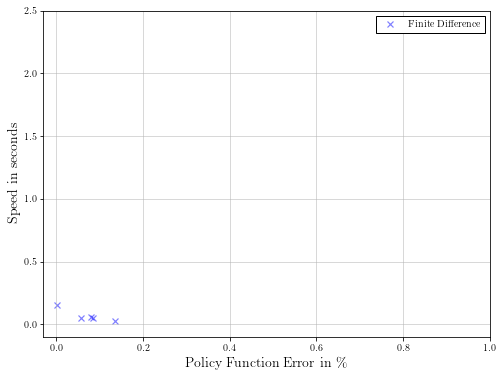

In [14]:
# Generate
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.7')
ax.set_xlim([-0.03,1])
ax.set_ylim([-0.1,2.5])
ax.set_ylabel(r'Speed in seconds', size=14)
ax.set_xlabel(r'Policy Function Error in \%', size=14)
    
# ax.set_xscale('log')
# ax.set_xlim([1e-3,2])

# Plot
ax.scatter(error_fd_av,time_fd_av,marker='x', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'blue', label = 'Finite Difference')
# ax.scatter(error_egm,time_egm, marker='+', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'red', label = 'Endogenous Grid')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.savefig('tradeoff.pdf')